### 导包

In [1]:
import pandas as pd
import numpy as np
import datetime
import calendar
import chardet

### 导入数据：1.无风险利率；2.上证50ETF日行情；3.上证50ETF期权日行情

In [2]:
rf=pd.read_csv('SHIBOR1月.csv')
odata = pd.read_csv('50ETF报价.csv',sep=',')
edata = pd.read_csv('50ETF_OPTION_INFO.csv',encoding='gbk',sep='\t')

### 处理数据格式（30s'）

In [3]:
rf['日期'] = pd.to_datetime(rf['日期'])
edata['date'] = pd.to_datetime(edata['date'])
odata['date'] = pd.to_datetime(odata['date'])
test = edata[edata['date'].isin(odata['date'].tolist())]
test['exercise_date'] = pd.to_datetime(test['exercise_date'])
test = test.sort_values(by='date')
test['time_to_maturity'] = test.apply(lambda x:(x['exercise_date']-x['date']).days,axis=1)
test['name2'] = test['name'].apply(lambda x:x.replace(x[5],''))
test['name3'] = test.apply(lambda x: str(x['date'])+x['name2'],axis=1)

g:\python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### 划分看涨看跌期权

In [5]:
call_sample = test[test['name'].apply(lambda x:True if '购' in x else False)==True]
put_sample = test[test['name'].apply(lambda x:True if '沽' in x else False)==True]
temp = put_sample[put_sample['name3'].isin(call_sample['name3'].tolist())].index.tolist()
sub_put_sample = put_sample.loc[temp,:]
sub_call_sample = call_sample[call_sample['name3'].isin(sub_put_sample['name3'].tolist())]

### 匹配看涨期权对应的看跌期权的价格（1min）

In [6]:
a = sub_call_sample['name3'].tolist()
b = sub_put_sample['name3'].tolist()
temp = [a.index(item) for idx,item in enumerate(b)]
temp = sub_call_sample.iloc[temp,:]
temp['put_price'] = sub_put_sample['settle_price'].tolist()

### 匹配各交易日的无风险利率和ETF成交金额（5.3s'）

In [11]:
date = temp['date'].tolist()
rate = [0 for i in range(len(temp))]
rate[0] = rf[rf['日期']==date[0]]['价格'].iloc[0]
etf_money = [0 for i in range(len(temp))]
etf_money[0] = odata[odata['date']==date[0]]['money'].iloc[0] 
for i in range(1,len(temp)):
    if date[i] == date[i-1]:
        rate[i] = rate[i-1]
        etf_money[i] = etf_money[i-1]
    else:
        rf_rate = rf[rf['日期']==date[i]]['价格'].iloc[0]
        money = odata[odata['date']==date[i]]['money'].iloc[0]
        rate[i] = rf_rate
        etf_money[i] = money
temp['rf'] = rate
temp['etf_money'] = etf_money

g:\python\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
g:\python\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


### 计算IMD（10s'）

由期权看涨看跌平价公式（PCP）可知：

$$q_{x}p +q_{x} S = q_{x}c + q_{x}Xe^{(-rT)}$$

$q_{x}$为ETF的成交量，p和c分别为看跌和看涨期权的价格，S为上证50ETF的收盘价，X为期权对应的行权价。

根据Feng（2016）提出的方法，将$q_{x}S$视作股票真实的成交金额$v_{x}$。利用期权市场每日的报价倒算上证50ETF的隐含成交量（隐含市场深度，IMD）：

$$\hat{q_{x}}=\frac{v_{x}}{c-p+Xe^{-rT}} $$

基于此，参考杨旸等（2019）的方法，为了消除量纲，构造隐含相对市场深度（IRMD），记作$\frac{q_{x}}{\hat{q_{x}}}$，其中$q_{x}$是真实成交量

In [17]:
IMD_list = []
for i in range(len(temp)):
    IMD = temp['etf_money'].iloc[i]/(temp['settle_price'].iloc[i]+temp['exercise_price'].iloc[i]*np.exp(-temp['rf'].iloc[i]/100*temp['time_to_maturity'].iloc[i]/365))
    IMD_list.append(IMD)

g:\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


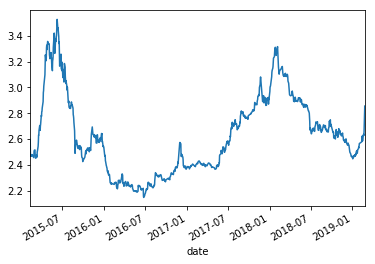

In [31]:
temp['IMD'] = IMD_list
temp2 = temp.groupby(temp['date']).mean()
temp2['IRMD'] = temp2['etf_money']/temp2['IMD']
temp2['IRMD'].plot()